# Introduction

In this notebook, I will be investigating the funnel data provided in the Analytics Discovery Exercise. The provided data set contains information on Guild's client companies, and the employee bases for each company that have been onboarded, and associated course enrollment information, as well as dates of the first two-way communication Guild had with each employee.



**Instructions were as follows** 

Build a 3 -5 slide presentation to present to the executive leadership team to cover:
  * Any interesting trends you find about our user base
  * Your understanding of the student funnel (given the sample data), and how we convert students, and any information relevant to the funnel conversion.
  * Any other interesting facts, data points or suggestions you’d like to share to demonstrate your ability to analyze and synthesize data in a compelling way. 


## Import and Connections

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime
from scipy.stats import ranksums, mannwhitneyu

In [2]:
pd.options.display.max_rows = 500
%matplotlib inline

In [3]:
working_dir = '/Users/jmbeck/Desktop/guild_eval'

## Data Load

The data set for the funnel will be loaded directly from the excel document stored locally.

In [4]:
flow_data = pd.read_excel(working_dir + '/data/Analytics Discovery exercise.xlsx')

Take a quick look at the structure of the data set.

In [5]:
flow_data.head()

,Student ID,Student ID Created Date,Enrollment Created At,Course Start Date,Employer,Educational Interest,First Two-way Communication,Student Birthdate,Course Name
0,00Q3600000lmLhEEAU,2018-02-08,2018-04-04,2018-04-06,Discover,NaN,2018-02-18,NaN,Mathematics Review
1,00Q3600000lmLhEEAU,2018-02-08,2018-04-04,2018-04-06,Discover,NaN,2018-02-18,NaN,First Year Experience Seminar
2,00Q3600000lmLhEEAU,2018-02-08,2018-04-04,2018-04-12,Discover,NaN,2018-02-18,NaN,Intro to Critical Thinking
3,00Q3600000lmLhEEAU,2018-02-08,2018-02-28,2018-04-06,Discover,NaN,2018-02-18,NaN,Mathematics Review
4,00Q3600000lmLhEEAU,2018-02-08,2018-02-28,2018-04-06,Discover,NaN,2018-02-18,NaN,First Year Experience Seminar


Some of this data looks similar to what we saw in the SQL Workbench data, although there is what appears to be some onboarding and communication data here as well.  Since things like course names and enrollment dates are added here I will refrain from attempting to join the SQL tables to this data set. (A quick check suggests IDs are of a different format between the two and they can't be joined anyway.) 

In [6]:
flow_data.dtypes

Student ID                             object
Student ID Created Date        datetime64[ns]
Enrollment Created At          datetime64[ns]
Course Start Date              datetime64[ns]
Employer                               object
Educational Interest                   object
First Two-way Communication    datetime64[ns]
Student Birthdate                     float64
Course Name                            object
dtype: object

In [7]:
flow_data.duplicated().sum()

24

Unfortunately there are some duplicate rows in this data set. We will drop them here.

In [8]:
flow_data = flow_data.drop_duplicates()

# EDA

In this section I will look at several features of the data:
  * Missingness per column
  * Total number of onboarded employees per company
  * Total number of conversations with employees per company
  * Total number of students enrolled in courses per company

**Missingness**

In [9]:
100*(flow_data.isnull().sum()/flow_data.shape[0])

Student ID                       0.000000
Student ID Created Date          0.000000
Enrollment Created At           98.740517
Course Start Date               98.899192
Employer                         0.337185
Educational Interest            99.980166
First Two-way Communication     96.335598
Student Birthdate              100.000000
Course Name                     98.899192
dtype: float64

Of the critical columns, roughly 98% of the values are missing.  This suggests that very few employees ultimately enroll in courses or have two-way conversations with Guild.

**Unique Students Per Employer**

In [10]:
flow_data.groupby('Employer')['Student ID'].nunique().sort_values(ascending=False)

Employer
Taco Bell                      10644
DaVita                          4423
Chipotle                        4272
Discover                         280
Walmart                          155
Lyft                             102
Mission43                         10
Hire Heroes                        9
Public Service Credit Union        5
Denver Public Schools              4
SEIU                               1
Lowe's                             1
Name: Student ID, dtype: int64

Filter down to students who have enrolled in a course

**Count of Unique Two-Way Communications per Employer**

In [11]:
flow_data[-flow_data['First Two-way Communication'].isnull()].groupby('Employer')['Student ID'].\
    nunique().sort_values(ascending=False)

Employer
DaVita                         311
Chipotle                       154
Discover                        30
Taco Bell                       23
Lyft                            22
Walmart                         17
Hire Heroes                      6
Public Service Credit Union      4
Mission43                        4
Denver Public Schools            3
Name: Student ID, dtype: int64

DaVita has the highest count of two-way conversations. Chipotle also has a fair number of conversations.

**Count of Unique Students Enrolling in Course Per Employer**

In [12]:
flow_data[-flow_data['Enrollment Created At'].isnull()].groupby('Employer')['Student ID'].\
    nunique().sort_values(ascending=False)

Employer
DaVita       45
Walmart       5
Discover      3
Mission43     2
Chipotle      2
Taco Bell     1
Name: Student ID, dtype: int64

DaVita once again appears to have roughly 1% of their overall population enrolled in courses. We'll dig more into that later.

In [13]:
flow_data[-flow_data['Enrollment Created At'].isnull()].\
    groupby(['Student ID', 'Course Name', 'Course Start Date']).size().head(10)

Student ID          Course Name                     Course Start Date
00Q3600000llQw1EAE  Composition I                   2018-03-07           2
                    Introduction to Psychology      2018-03-07           2
                                                    2018-05-15           2
00Q3600000llRcpEAE  Health Information Techn and A  2018-04-09           2
                                                    2018-05-15           2
                    Healthcare Finance              2018-04-09           2
                                                    2018-05-15           2
                    Human Resource Management       2018-04-09           2
                                                    2018-05-15           2
                    Leadership and Team Developmt   2018-04-09           2
dtype: int64

Example of the duplicate enrollments here.

In [14]:
flow_data[flow_data['Student ID'] == '00Q3600000llQw1EAE'].\
    sort_values(by=['Course Name', 'Course Start Date','Enrollment Created At'], ascending=True)

,Student ID,Student ID Created Date,Enrollment Created At,Course Start Date,Employer,Educational Interest,First Two-way Communication,Student Birthdate,Course Name
73,00Q3600000llQw1EAE,2018-02-01,2018-02-06,2018-03-07,DaVita,NaN,2018-02-01,NaN,Composition I
70,00Q3600000llQw1EAE,2018-02-01,2018-03-07,2018-03-07,DaVita,NaN,2018-02-01,NaN,Composition I
71,00Q3600000llQw1EAE,2018-02-01,2018-02-06,2018-03-07,DaVita,NaN,2018-02-01,NaN,Introduction to Psychology
68,00Q3600000llQw1EAE,2018-02-01,2018-03-07,2018-03-07,DaVita,NaN,2018-02-01,NaN,Introduction to Psychology
72,00Q3600000llQw1EAE,2018-02-01,2018-02-06,2018-05-15,DaVita,NaN,2018-02-01,NaN,Introduction to Psychology
69,00Q3600000llQw1EAE,2018-02-01,2018-03-07,2018-05-15,DaVita,NaN,2018-02-01,NaN,Introduction to Psychology


For students who enrolled in courses, it looks like there can be duplicate enrollments.  I'll ensure that I aggregate by enrollment as I am working on downstream analyses. 

## Funnel Timings

Now that we have a rough idea of what the funnel for onboarding to course enrollment looks like in terms of raw numbers, I will start digging into the dates associated with these data.

### Enrollment Date

In [15]:
flow_data['Student ID Created Date'].min()

Timestamp('2018-02-01 00:00:00')

In [16]:
flow_data['Student ID Created Date'].max()

Timestamp('2018-02-15 00:00:00')

It turns out we are looking at a very narrow window of employees that were onboarded in a 2 week window in February of 2018.

### Course Enrollment Range

In [17]:
flow_data['Enrollment Created At'].min()

Timestamp('2017-03-28 00:00:00')

In [18]:
flow_data['Enrollment Created At'].max()

Timestamp('2018-05-17 00:00:00')

We are generally looking at the first half of 2018 in terms of course enrollment dates. There are some course enrollments in 2017, but those were isolated to a small number of users.  I would guess those are coming from either an employee testing for the company that was later onboarded with the batch load of all employees, or another unknowable issue for the purposes of this isolated evaluation.

### First Touchpoint

I am interested in knowing the time in days between the student ID being created in the system (what I will call onboarding) and when the first two-way communication occurred.  

In [19]:
flow_data['time_to_first_contact'] = flow_data['First Two-way Communication'] - flow_data['Student ID Created Date']
flow_data['time_to_first_contact'] = flow_data.time_to_first_contact.apply(lambda x: x.days)

### First Course Enrollment

Similarly, I am interested in knowing the time in days between the student ID being created in the system (what I will call onboarding) and a student's first enrollment date. 

In [20]:
flow_data['course_enrollment_delay'] = flow_data['Enrollment Created At'] - flow_data['Student ID Created Date']
flow_data['course_enrollment_delay'] = flow_data.course_enrollment_delay.apply(lambda x: x.days)

### Aggregate Stats by Employee

Several employees have multiple enrollments for the same course in the data set, so I will need to aggregate data down to have a single unique record per student id for account-level metrics like first enrollment date and time to the initial two-way communication. Since these values are at the student-level, I can just take a min. 

In [21]:
customer_funnel = flow_data.groupby('Student ID').agg({'course_enrollment_delay':min, 'time_to_first_contact':min})

In [22]:
customer_funnel.tail(10)

,course_enrollment_delay,time_to_first_contact
Student ID,,
00Q3600000lnAUOEA2,NaN,NaN
00Q3600000lnAZPEA2,NaN,NaN
00Q3600000lnArBEAU,NaN,84.0
00Q3600000lnAwqEAE,NaN,1.0
00Q3600000lnB0OEAU,NaN,NaN
00Q3600000lnB1REAU,NaN,1.0
00Q3600000lnB2AEAU,1.0,1.0
00Q3600000nfyIVEAY,NaN,NaN
00Q3600000prkIeEAI,NaN,0.0


**Missingness in the Aggregated Data**

In [23]:
100*(customer_funnel.isnull().sum()/customer_funnel.shape[0])

course_enrollment_delay    99.699594
time_to_first_contact      97.096080
dtype: float64

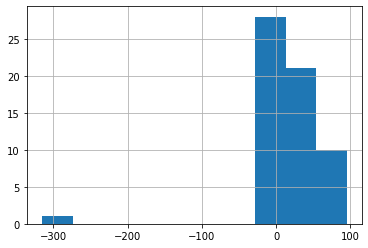

In [24]:
customer_funnel.course_enrollment_delay.hist()

Let's filter enrollment delay down to only look at people who enrolled after their ID was created.  (This is probably caused by a system issue loading data). 

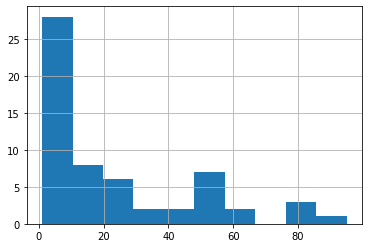

In [25]:
customer_funnel.query('course_enrollment_delay >= 0').course_enrollment_delay.hist()

Most students have enrolled in courses very quickly after they were onboarded into the Guild system.  That is a bit surprising and not what I would have expected, although if this was a new platform for the company, employees were excited to start using it immediately.

In [26]:
customer_funnel['enrolled'] = -customer_funnel['course_enrollment_delay'].isnull()

In [27]:
customer_funnel.groupby('enrolled').time_to_first_contact.describe()

,count,mean,std,min,25%,50%,75%,max
enrolled,,,,,,,,
False,525.0,14.165714,22.225191,-92.0,0.0,4.0,20.0,96.0
True,55.0,7.818182,15.509962,0.0,0.0,2.0,7.0,82.0


Of the people who Guild had a two-way communication with, the time delay looks like it may be slightly shorter for those who ultimately enrolled in courses. 

We'll need to see if this is even statistically significant.

enrolled
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: time_to_first_contact, dtype: object

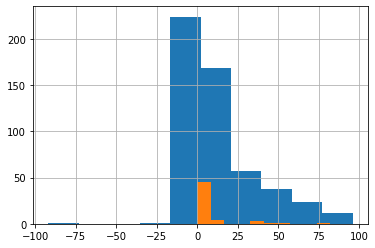

In [28]:
customer_funnel.groupby('enrolled').time_to_first_contact.hist()

To run a non-parametric test on this, I will filter down to just the employees who Guild had a two-way conversation with, and see if there is any significant difference in the distribution of time-to-first-contact between groups.  Essentially, I will be trying to understand if the slight decrease in the median is significant.

In [29]:
customers_convoed = customer_funnel[-(customer_funnel.time_to_first_contact.isnull())]

Now I will split this data set into employees who ultimately enrolled in a course, and those who didn't.

In [30]:
enrolled = customers_convoed[(customers_convoed.enrolled)].time_to_first_contact
not_enrolled = customers_convoed[-(customers_convoed.enrolled)].time_to_first_contact

And now we will run the Mann-Whitney U non-parametric test against the data. Two concerns are the relatively small sample size and the fairly large imbalance in the data. 

In [31]:
mannwhitneyu(not_enrolled, enrolled, alternative='two-sided')

MannwhitneyuResult(statistic=16297.0, pvalue=0.10919988350934175)

Based on the output of the statistical test there does not appear to be a significant difference communication time for people who ultimately enrolled in classes vs those who didn't. 

### Funnel Exception

There are a few students in the funnel who have signed up for courses but have not actually had a two-way conversation with Guild. Given the small number we have seen, it is difficult to tell how likely it is that students would sign up without first having a two-way conversation. 

In [32]:
customer_funnel[(customer_funnel.time_to_first_contact.isnull()) & (customer_funnel.enrolled)]

,course_enrollment_delay,time_to_first_contact,enrolled
Student ID,,,
00Q3600000llz8KEAQ,17.0,NaN,True
00Q3600000lm0gXEAQ,-315.0,NaN,True
00Q3600000lmHPOEA2,13.0,NaN,True
00Q3600000lmIwyEAE,1.0,NaN,True
00Q3600000lmVt5EAE,5.0,NaN,True


## Most Popular Courses

In [33]:
flow_data.drop_duplicates(subset=['Student ID', 'Course Start Date', 'Course Name'])['Course Name'].value_counts()

Intro to Psychology                                  7
First Year Experience Seminar                        7
Issues in Aging                                      5
Operations Management                                3
Nurse as Professional                                3
Developmental Writing - 8 Week                       3
Intro to Critical Thinking                           3
Biology I (with Lab)                                 2
Healthcare Finance                                   2
Strat Mgmt for Healthcare Orgs                       2
Quality Management                                   2
High School Completion                               2
Leadership and Team Developmt                        2
Introduction to Psychology                           2
Organizational Development                           2
Org Design and Delivery Sys                          2
Health Information Techn and A                       2
High School Completion Program                       2
Leadership

There really aren't that many courses that have been taken by multiple people yet. 

### Key Findings in the Data:
  * The provided data set appears to consist of onboarded employees for several major companies that were added to the system in the first two weeks of February 2018. Course enrollment is provided for these employees for what appears to be the first half of 2018.
  * The funnel appears to consist of onboarding an employer's employee base, a two-way conversation with some subset of the employees, and hopefully course enrollment. I assume there is some passive benefit enrollment discussion that happens between onboarding and two-way conversations.
  * Conversion is fairly low. Of the employee base, Guild appears to have had conversations with roughly 2.9% of the employee base.  The data does not suggest that employees will sign up for courses without that conversation, so it would appear getting in front of the employee is critical. 
  * There are issues with duplicate enrollment records in this data set that I cleaned and removed in order to get a better estimate of the conversion rates.